In [19]:
symbol  = "#PLTR"
import torch
print(torch.cuda.is_available())  # Sollte True ausgeben, wenn eine GPU erkannt wird
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Zeigt das verwendete Gerät


True
cuda


In [20]:
import pandas as pd
#import yfinance as yf
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

import os
from datetime import datetime

folderpath_models ="/Users/Shared/ai_work/Trainingdata/models/neuralprophet/modelfiles/"
folderpath_traininglogs ="/Users/Shared/ai_work/Trainingdata/models/neuralprophet/traininglogs/"
folderpath_charts = "/Users/Shared/ai_work/Trainingdata/models/neuralprophet/charts/"
folderpath_historie ="/Users/Shared/ai_work/Trainingdata/ml_data/yh_his/D1/"
folderpath_results = "/Users/Shared/ai_work/Trainingdata/ml_results/fb_nrp/"
folderpath_analyse = "/Users/Shared/ai_work/Trainingdata/ml_analyse/fb_nrp/"



# 🟢 Step 1: Download Tesla stock data
#ticker = "TSLA"

filepath_model = folderpath_models+symbol+".pth"
#filepath_model = folderpath_models+symbol+".np"

#df = yf.download(ticker, period="5y", interval="1d")
df = pd.read_csv (folderpath_historie+symbol+".csv")
n_pred_days = 100
n_lags_days =  50
n_learning_rate  = 0.01
n_epochs = 400
n_batch_size = 16

isretain = 1
check_file = 0 

lastBars = 0
n_tail = 500
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df_his["date"]) 
df = df[:len(df) - lastBars]

# 🟢 Step 2: Preprocess data for NeuralProphet
df.reset_index(inplace=True)  # Reset index to get 'Date' column
df = df.rename(columns={"date": "ds", "close": "y"})  # Rename columns
df["ds"] = pd.to_datetime(df["ds"])  # Ensure 'ds' is datetime
df = df[["ds", "y"]]  # Keep only required columns
if n_tail > 0 : df = df.tail (n_tail)
# 🟢 Step 3: Initialize and fit NeuralProphet model
#model = NeuralProphet(daily_seasonality=True)

# Prüfe, ob CUDA oder MPS verfügbar ist
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

#model = NeuralProphet(trainer_kwargs={"accelerator": device})


if os.path.exists(filepath_model):check_file = 1
   


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/1966211915.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df_his["date"])



In [21]:
def trainCheck (symbol, n_epochs, n_batch_size, n_tail, n_learning_rate,  
                d_seasonality, w_seasonality,y_seasonality,  df,  df_log,  model_no ):
     
     df = df.tail(n_tail)
    
     model = NeuralProphet(daily_seasonality=d_seasonality, weekly_seasonality=w_seasonality, yearly_seasonality=y_seasonality , seasonality_mode="additive", 
                      learning_rate=n_learning_rate, 
                      epochs = n_epochs, batch_size = n_batch_size
                      )
     
     metrics = model.fit(df, freq="B")
     loss = metrics['Loss'].values[-1]
     
     
     model_file_name = symbol +str(model_no)+".pth"
     filepath_model = folderpath_models + model_file_name

     torch.save(model, filepath_model)
     now = datetime.now()
     

     new_row = pd.DataFrame({'n_epochs': [n_epochs], 'n_batch_size': [n_batch_size], 'n_tail': [n_tail] , 'loss': [loss], 'model':[model_file_name], 'created':[now], 
                             'learning_rate':[n_learning_rate], 'daily_seasonality': [d_seasonality], 'weekly_seasonality':[w_seasonality],  'yearly_seasonality':[y_seasonality]})
     df_log = pd.concat([df_log, new_row], ignore_index=True)
     return df_log
     
     #training_check= f"Learning Rate {n_learning_rate} / epochs: {n_epochs} / n_batch_size: {n_batch_size} / n_tail:  {n_tail}: Loss = {metrics['Loss'].values[-1]}"
#{}
    

In [22]:
import csv
def createResult (symbol):
     #folderpath_results = "D:/OneDrive/AI Workspace/results/nrp_results/"
     csvfileresult  = folderpath_results+symbol + ".csv"
     with open(csvfileresult , 'w', newline='') as csvfilerow:
                           fieldnames = ['Symbol','Type','Date','Close','Source','Change']
                           writer = csv.DictWriter(csvfilerow, fieldnames=fieldnames)
                           writer.writeheader()

In [23]:
def analyseForecast (forecast, df):
    df_change = forecast
    df_change ["change"] = round ( df_change['yhat1'].pct_change() , 3) 
    
    forecast["mean"] = forecast["yhat1"].mean()
    #forecast["mean"] = forecast["yhat1"].mean()

    lastclose = df["y"].iloc[-1]
    lastdate = df["ds"].iloc[-1]
    lasttrend_close = forecast["trend"].iloc[-1]
    lasttrend_date  = forecast["ds"].iloc[-1]
    firsttrend_close = forecast["trend"].iloc[1:2]
    firsttrend_date  = forecast["ds"].iloc[1:2]
    lasttrend_close = forecast["trend"].iloc[-1]
    lasttrend_date  = forecast["ds"].iloc[-1]

    trend_change = (lasttrend_close - firsttrend_close)/firsttrend_close
    endclose = round( (lastclose + lastclose *trend_change),2)
    trend_change
    lasttrend_close

    # Create a list of dates (ds) and corresponding values (y)
    df_trend  = {
      'ds': [lastdate, lasttrend_date],
      'trend_close': [float(lastclose), float(endclose)]
    }
    df_trend = pd.DataFrame(df_trend)
    columns = ['cal']

   # Create an empty DataFrame
    df_cal = pd.DataFrame(columns=columns)
    i= 0 
    fc = lastclose
    #df_change['cal'] = 0
    #print (df_change)

    for s in df_change.values: 
        i= i +1
       
        #if i == 1: fc = lastclose
        if i > 1 : 
           change =  s[6]
           
           fc = fc+ fc* change
        
      
        #df_change['cal'][i] = fc
        new_row = pd.DataFrame({'cal': [fc]})
        df_cal = pd.concat([df_cal, new_row], ignore_index=True)
        
        
   # Convert the dictionary into a pandas DataFrame
    df_change ['cal']=  df_cal ['cal']
    filepath_result =folderpath_analyse+symbol+".csv"
    df_change.to_csv (filepath_result)
    
    return df_trend, df_change



In [24]:
def plotResult (symbol, df,df_his, forecast, df_trend , df_change, model_file, isbestmodel):
    
    plt.figure(figsize=(12, 6))
    df = df.tail(200)
    #plt.plot(df_trend["ds"], df_trend["trend_close"], label="Historical Data", color="pink")
    plt.plot(df_trend["ds"], df_trend["trend_close"], label="Forecast", color="red",  linestyle='--') 
    plt.plot(df_change["ds"], df_change["cal"], label="CAL FC", color="green",  linestyle='-') 
    plt.plot(df["ds"], df["y"], label="Historical Data", color="blue")
    plt.plot(df_his["date"], df_his["close"], label="IS HIS", color="Magenta")

    # Plot predicted stock prices
    plt.plot(forecast["ds"], forecast["mean"], label="mean", color="black")
    plt.plot(forecast["ds"], forecast["yhat1"], label="Predicted Data", color="red")
    plt.plot(forecast["ds"], forecast["trend"], label="Predicted trend", color="green")

    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.title(f"{symbol} Stock Price Prediction (Next {n_pred_days} Days)  with model  {model_file} {isbestmodel} ")
    plt.legend()
    plt.grid()
    # Save to file
    import os

    folder_path = folderpath_charts + symbol+"/"

# Check if the folder exists, if not, create it
    if not os.path.exists(folder_path): os.makedirs(folder_path)
   

    plt.savefig( folder_path + model_file+isbestmodel+"_chart.png", dpi=300, bbox_inches='tight')
   # Show plot
    #plt.show()


In [25]:
def getBestModelFile (df_log):
    
    
    df_sorted_desc = df_log.sort_values(by='loss', ascending=True)
    
    first_row = df_sorted_desc.iloc[0]
    
    #model_file = first_row['model'][0]
    model_file = first_row["model"]
    
    return model_file


In [26]:
def getForecastByModelFile (symbol, model_file, df , df_his , isbestmodel):
   
   filepath_model = folderpath_models + str(model_file)
   if os.path.exists(filepath_model):
     #model = torch.load(filepath_model)
     model = torch.load(filepath_model, weights_only=False)

     future = model.make_future_dataframe(df, periods=n_pred_days )
     forecast = model.predict(future)
     df_trend , df_change = analyseForecast (forecast, df)

     plotResult (symbol, df,df_his, forecast, df_trend, df_change,  model_file , isbestmodel)
   else: 
    print ("Load model failed")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).vie

Epoch 1:   0%|          | 1/200 [00:00<00:00, 1188.19it/s]

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:29<?, ?it/s, v_num=25, train_loss=0.0908, reg_loss=0.000, MAE=27.90, RMSE=45.00, Loss=0.0907, RegLoss=0.000]


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/908274947.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_log = pd.concat([df_log, new_row], ignore_index=True)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after group

Training: |          | 0/? [00:42<?, ?it/s, v_num=26, train_loss=0.00422, reg_loss=0.000, MAE=7.730, RMSE=9.170, Loss=0.00422, RegLoss=0.000]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).vie

Epoch 200: 100%|██████████| 200/200 [00:00<00:00, 728.21it/s]   
Training: |          | 0/? [00:42<?, ?it/s, v_num=27, train_loss=0.00554, reg_loss=0.000, MAE=5.910, RMSE=7.070, Loss=0.00554, RegLoss=0.000]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).vie

Training: |          | 0/? [02:25<?, ?it/s, v_num=28, train_loss=0.00276, reg_loss=0.000, MAE=5.690, RMSE=6.970, Loss=0.00276, RegLoss=0.000]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).vie


Training: |          | 0/? [02:08<?, ?it/s, v_num=29, train_loss=0.00352, reg_loss=0.000, MAE=6.880, RMSE=8.170, Loss=0.00352, RegLoss=0.000]


WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.6% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.42it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'trend_close': [float(lastclose), float(endclose)]



WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cal = pd.concat([df_cal, new_row], ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.6% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 314.68it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'trend_close': [float(lastclose), float(endclose)]

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cal = pd.concat([df_cal, new_row], ignore_index=True)



WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.6% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 330.55it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'trend_close': [float(lastclose), float(endclose)]

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cal = pd.concat([df_cal, new_row], ignore_index=True)



WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.6% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.55it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'trend_close': [float(lastclose), float(endclose)]

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cal = pd.concat([df_cal, new_row], ignore_index=True)



WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.6% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/aiubuntu01/anaconda3/envs/fbprophet/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 319.52it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'trend_close': [float(lastclose), float(endclose)]

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_62525/855750391.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cal = pd.concat([df_cal, new_row], ignore_index=True)



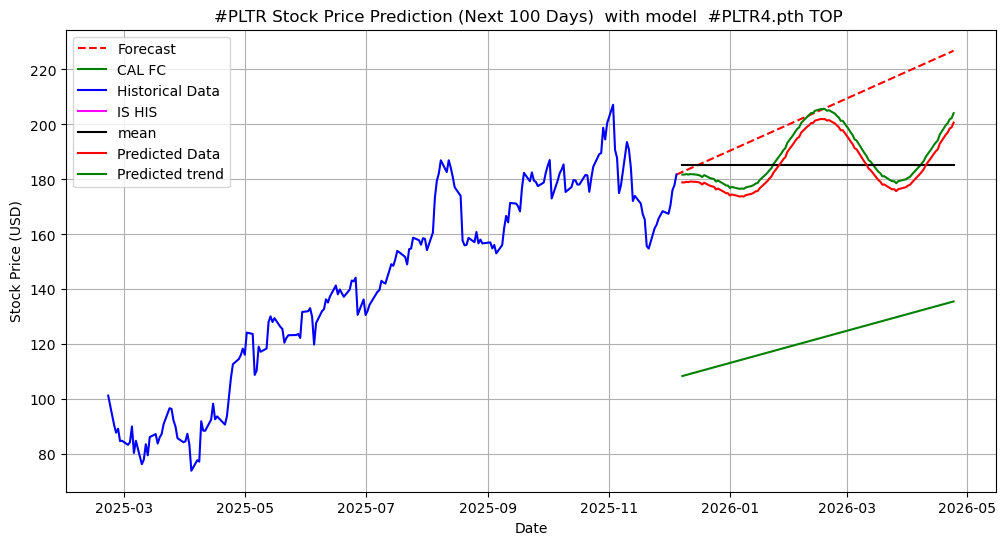

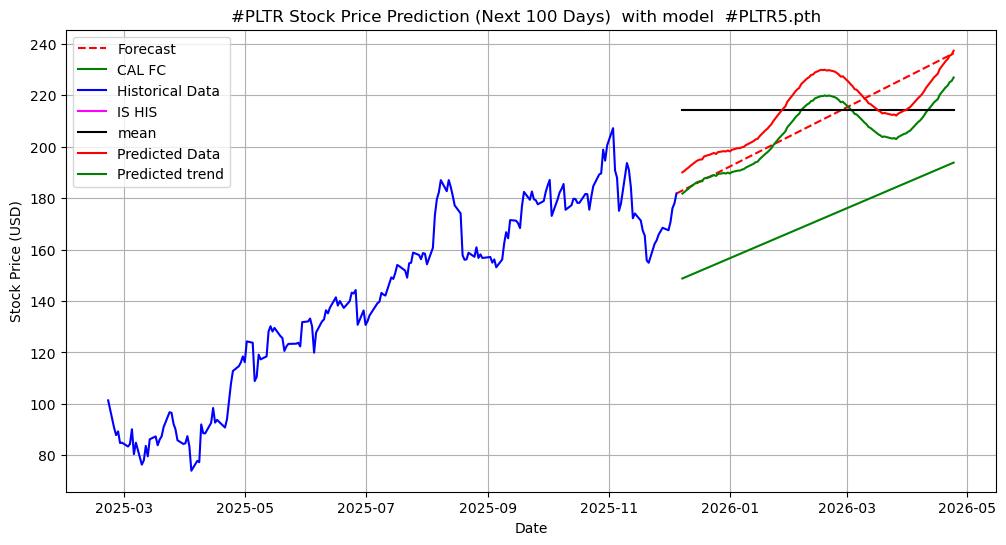

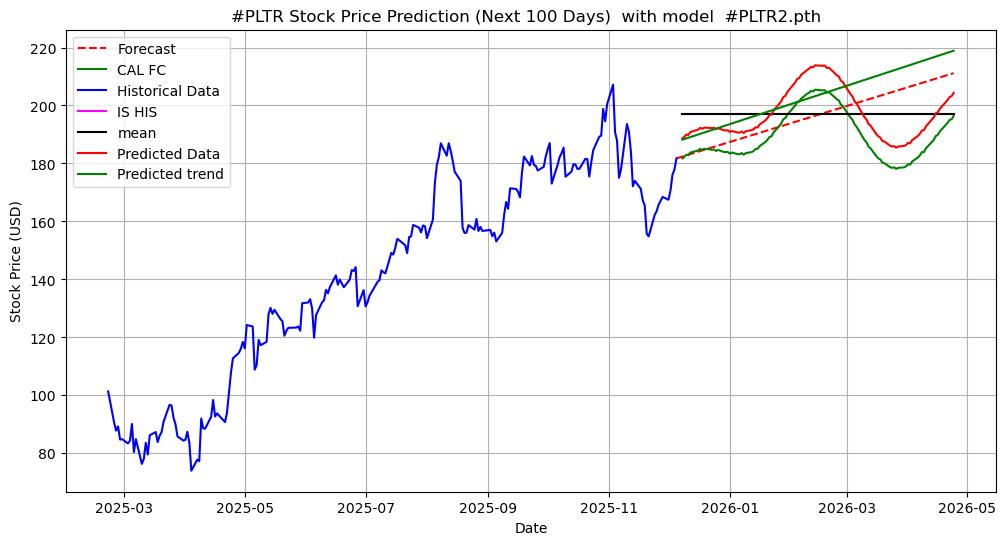

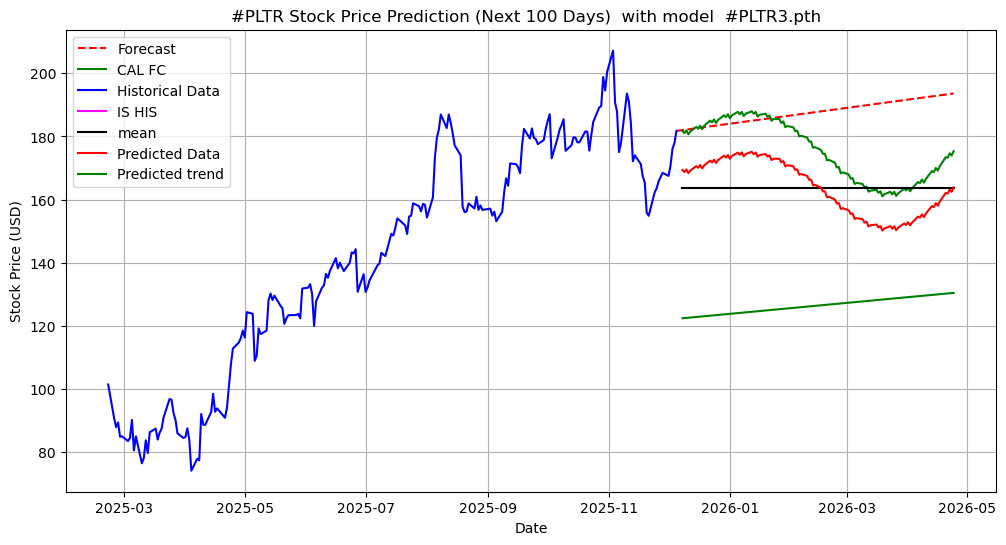

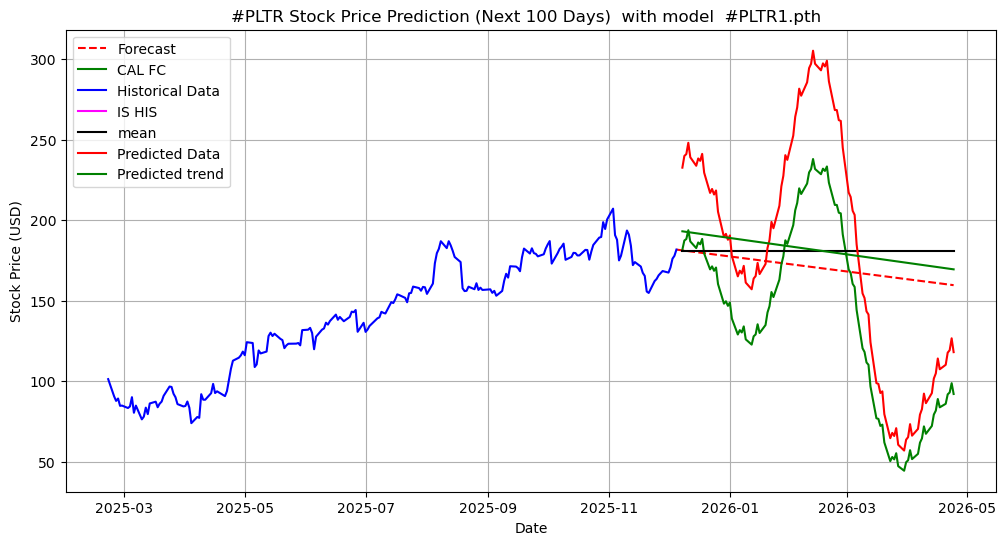

In [27]:
#df_log = {'n_epochs', 'n_batch_size','n_tail', 'loss'}

model = NeuralProphet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True , seasonality_mode="additive", 
                      learning_rate=n_learning_rate, 
                      epochs = n_epochs, batch_size = n_batch_size
                      )
# Define column names
columns = ['n_epochs', 'n_batch_size', 'n_tail','loss','model','learning_rate','daily_seasonality', 'weekly_seasonality', 'yearly_seasonality', 'created']

# Create an empty DataFrame
df_log = pd.DataFrame(columns=columns)

filepath_traninglog = folderpath_traininglogs+symbol +".csv"

checkmodel_exist = 0 
model_file =""

best_model_file = model_file

if os.path.exists(filepath_traninglog):
    df_log = pd.read_csv (filepath_traninglog)
  
    best_model_file = getBestModelFile (df_log)
    print ("Model file: ", model_file)
    #df_sorted_desc.tail(1)
    #model_file = "#NVDA5.pth"

#Retrain models
if best_model_file =="":
  df_log = trainCheck (symbol, 200,16,200, 0.001, False, True, True, df, df_log, 1)
  df_log = trainCheck (symbol, 200,16,400,0.001 ,False, True, True, df, df_log,2)
  df_log = trainCheck (symbol, 200,8,200,0.002,False,  True, True, df, df_log,3)
  df_log = trainCheck (symbol, 400,8,400,0.005, False, True, True, df, df_log,4)
  df_log = trainCheck (symbol, 600,16,400,0.001, False, True, True, df, df_log,5)
  #df_log = df_log.sort_values(by='loss', ascending=True)
  df_log.to_csv (folderpath_traininglogs+symbol +".csv")
  df_log = pd.read_csv (filepath_traninglog)
 
  best_model_file = getBestModelFile (df_log)




   

df_log = df_log.sort_values(by='loss', ascending=True)
getForecastByModelFile (symbol, best_model_file, df , df_his, "TOP" )


for row in df_log.values:
  isbestmodel =""
  model_file = row[5]
  if model_file != best_model_file: getForecastByModelFile (symbol, model_file, df , df_his, "" )

